<a href="https://www.kaggle.com/code/siddp6/cifar-10-cnn?scriptVersionId=138720749" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Convolutional Neural Networks
---
In this notebook, we train a **CNN** to classify images from the CIFAR-10 database.

The images in this database are small color images that fall into one of ten classes; some example images are pictured below.

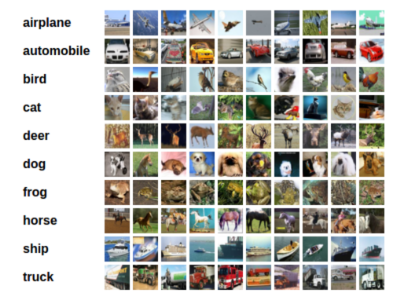

### Test for [CUDA](http://pytorch.org/docs/stable/cuda.html)

Since these are larger (32x32x3) images, it may prove useful to speed up your training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, only they utilize GPU's for computation.

In [1]:
import torch 
import numpy as np

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')    

CUDA is available!  Training on GPU ...


---
## Load the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a minute. We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

Note that of course:

- The resize and crop should be the same as applied during training for best performance
- The normalization should be the same between training and inference (validation and test)

In [41]:
import torchvision.transforms as T

def get_transforms(rand_augment_magnitude=15):
    
    # These are the per-channel mean and std of CIFAR-10 over the dataset
    mean = (0.49139968, 0.48215827, 0.44653124)
    std = (0.24703233, 0.24348505, 0.26158768)

    train_transforms = T.Compose([
        T.Resize(40),
        T.RandomCrop(32),
        T.RandomHorizontalFlip(.5),
        T.RandAugment(num_ops=2, magnitude=rand_augment_magnitude, interpolation=T.InterpolationMode.BILINEAR),
        T.transforms.ToTensor(),
        T.transforms.Normalize(mean, std)
    ])

    val_transforms = T.Compose([
        T.Resize(40),
        T.RandomCrop(32),
        T.transforms.ToTensor(),
        T.transforms.Normalize(mean, std)
    ])

    test_transforms = T.Compose([
        T.Resize(40),
        T.RandomCrop(32),
        T.transforms.ToTensor(),
        T.transforms.Normalize(mean, std)
    ])
    
    return train_transforms, val_transforms, test_transforms

In [42]:
import multiprocessing
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler


def get_loader(root="data", valid_size = .2, batch_size = 64, num_workers = multiprocessing.cpu_count()):
    train_data = datasets.CIFAR10(root, train=True, download=True, transform=train_transforms)
    valid_data = datasets.CIFAR10(root, train=True, download=True, transform=val_transforms)
    test_data = datasets.CIFAR10(root, train=False, download=True, transform=test_transforms)


    shuffled_indices = torch.randperm(len(train_data)) # Random index [0,len(train_data)-1]
    train_idx, valid_idx = shuffled_indices[:int(len(shuffled_indices)*.8)], shuffled_indices[int(len(shuffled_indices)*.8):]

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        dataset=train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers
    )

    test_loader = torch.utils.data.DataLoader(
        dataset=test_data, batch_size=batch_size, num_workers=num_workers
    )
    
    return train_loader, valid_loader, test_loader

In [43]:
# specify the image classes
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

NOTE: 
- It is important to use BatchNorm before DropOut. 
- The latter drops some connections only at training time, so placing it before BatchNorm would cause the distribution seen by BatchNorm to be different between training and inference.

In [44]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, n_classes = 10):
        super(Net, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(16, 32, 3, padding=1),  
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            
            nn.Conv2d(32, 64, 3, padding=1),  
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, 3, padding=1),  
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Flatten(),  
            
            nn.Linear(128 * 2 * 2, 500), 
            nn.Dropout(0.5),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            
            nn.Linear(500, n_classes),
            
        )
    
    def forward(self, X):
        return self.model(X)

In [46]:
model = Net()
print(model)

Net(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): R

## How many parameters?

Now that you built the network, can you compute with pen and paper how many parameters does your network have? Does your answer match the output of the following cell?

In [14]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

360430

## Visualize your network (optional)

You can visualize your achitecture by using netron.app. Just execute the following cell (which will save the network to a file called "cifar10_network.pt" in this directory), then download the produced `cifar10_network.pt` to your computer. Finally, go to [Netron.app](https://netron.app) and click on `Open Model`, and select the file you just downloaded.

In [16]:
scripted = torch.jit.script(model)
torch.jit.save(scripted, "cifar10_network.pt")


# Learning Rate Scheduler + Hyperparameter Optimization
Let's also use two other tricks we have just learned: the learning rate scheduler, that changes the learning rate as the training progresses, and the hyperparameter optimization that optimizes the choices to maximize performance.

Let's start by writing an optimize function that leverages the Learning Rate scheduler:

---
## Train the Network

Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting. (In fact, in the below example, we could have stopped around epoch 33 or so!)

In [17]:
!pip install livelossplot

In [18]:
import matplotlib.pyplot as plt
# This is a plotting function
def after_subplot(ax: plt.Axes, group_name: str, x_label: str):
    """Add title xlabel and legend to single chart"""
    ax.set_title(group_name)
    ax.set_xlabel(x_label)
    ax.legend(loc="center right")

In [19]:
from livelossplot import PlotLosses
from tqdm import tqdm
import utility
from livelossplot.outputs import MatplotlibPlot

def run_model(model, epochs, train_loader, val_loader, optimizer, criterion, save_path, is_cuda=False, interactive_tracking=False):
    
    if interactive_tracking:
        liveloss = PlotLosses(outputs=[MatplotlibPlot(after_subplot=after_subplot)])
    else:
        liveloss = None
    
    val_loss_min = None
    logs = {}
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", verbose=True, threshold=.01)

    for epoch in tqdm(
            range(epochs),
            desc="Epochs",
            total=epochs,
            leave=True,
            ncols=80
        ):
        train_loss = utility.run(
            model=model, 
            optimizer=optimizer, 
            criterion=criterion,
            data_loader=train_loader, 
            is_cuda=is_cuda, 
            mode="Train"
        )
        val_loss = utility.run(
            model=model, 
            optimizer=None, 
            criterion=criterion,
            data_loader=train_loader, 
            is_cuda=is_cuda, 
            mode="Val"
        )
        print(
            "Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}".format(
                epoch + 1, train_loss, val_loss
            )
        ) 
        
        if val_loss_min is None or ((val_loss_min - val_loss) / val_loss_min > 0.1):
            torch.save(model.state_dict(), save_path)
            val_loss_min = val_loss
        
        scheduler.step(val_loss)
        
        if interactive_tracking:
            logs['loss'] = train_loss
            logs['val_loss'] = val_loss
            liveloss.update(logs)
            liveloss.send()

Now let's write a function that train and validate our model given some hyperparameters. Let's consider for simplicity just two hyperparameters: the learning rate and the strength of the data augmentation in `RandAugment`.

We are also going to track our experiments with `mlflow`.

In [21]:
!pip install mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 59.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 9.0 MB/s eta 0:00:00
  Created wheel for databricks-cli: filename=databricks_cli-0.17.7-py3-none-any.whl size=143882 sha256=841692b0777efe33ec8b4100e97f00384f03536b1dd6e02c7913227b7728c08b
  Stored in directory: /root/.cache/pip/wheels/ae/63/93/5402c1a09c1868a59d0b05013484e07af97a9d7b3dbd5bd39a
Successfully built databricks-cli


In [31]:
import mlflow

def train_one_model(learning_rate, rand_augment_magnitude, epochs):
    train_transforms, val_transforms, test_transforms = get_transforms()
    train_loader, valid_loader, test_loader = get_loader()
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=1e-5)
    
    with mlflow.start_run():
        run_model(model, epochs, train_loader, valid_loader, optimizer, criterion, save_path="cifar10_best_valid.pt", is_cuda=train_on_gpu, interactive_tracking=True)
        model.load_state_dict(torch.load("cifar10_best_valid.pt"))
        
        val_loss, preds, actuals, class_correct, class_total = utility.test_run(model, criterion, valid_loader, train_on_gpu)
        
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("rand_augment_magnitude", rand_augment_magnitude)
        
        val_accuracy =  100. * sum(class_correct) / sum(class_total)
        mlflow.log_metric("val_loss", val_loss)
        mlflow.log_metric("val_acc", val_accuracy)     
        
        mlflow.log_artifact("cifar10_best_valid.pt")

## Random Search
Let's use the random search technique to explore our hyperparameters:

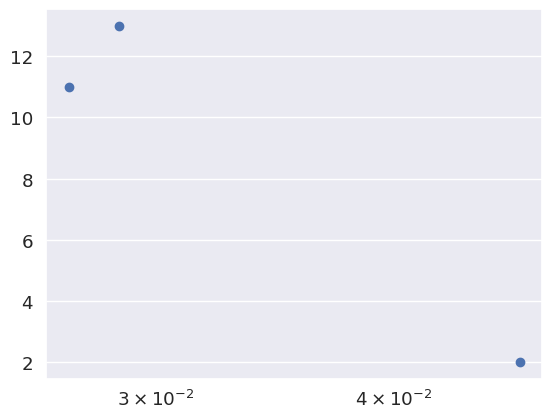

In [32]:
# Make a random grid of learning rate and rand_augment_magnitude
min_lr = 0.01
max_lr = 0.1

# Here you can decide how many experiments to run
# Run between 5 and 20. The more you run the better
# your results might be, but of course it will take
# longer
# Normally you would use a lot more than that, which is why
# you typically do hyperparam optimization in the cloud so 
# all the experiments can run in parallel
n_grid = 3

# Sample log-uniformly the learning rate
lrs = 10**(np.random.uniform(np.log10(min_lr), np.log10(max_lr), n_grid))
# Sample uniformly the rand augment transform strength
r_a_mag = np.random.randint(1, 15, n_grid)

# Plot our grid
_ = plt.scatter(lrs, r_a_mag)
_ = plt.xscale("log")

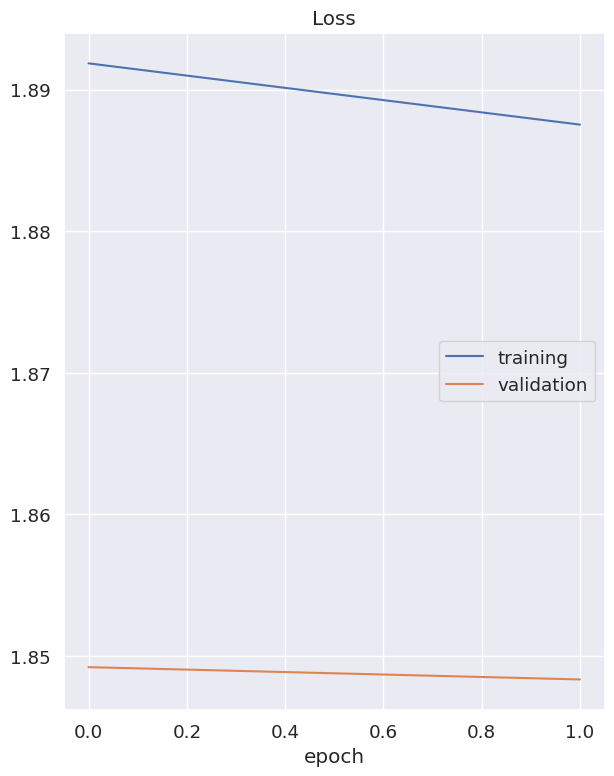

Testing: 100%|████████████████████████████████| 157/157 [00:09<00:00, 15.97it/s]


In [33]:
# Run our experiments
for lr, rand_aug_mag in zip(lrs, r_a_mag):
    train_one_model(lr, rand_aug_mag, epochs=2)

###  Load the Model with the Lowest Validation Loss

In [35]:
import mlflow

runs = mlflow.search_runs()
sorted_runs = runs[
    [
        "run_id",
        "params.learning_rate",
        "params.rand_augment_magnitude",
        "metrics.val_loss",
        "metrics.val_acc",
    ]
].sort_values(by='metrics.val_loss')
sorted_runs

,run_id,params.learning_rate,params.rand_augment_magnitude,metrics.val_loss,metrics.val_acc
0,c25e3f9efab24d13b68fd93aab8d5121,0.028696340467543466,13,0.461616,10.97
1,f28a43f602b14b3bbd56e04c95ed8ef3,0.02701881358539477,11,0.462015,11.04
2,132afd246d0c49958a93c31cab9ddda8,0.04659569772412356,2,0.463212,10.89
3,a1b83444bc114793a886b9432991ef3f,0.016293103020347918,5,0.463416,NaN


In [36]:
from mlflow.tracking import MlflowClient

# Get the id with the lowest val_loss
lowest_loss_id = sorted_runs.iloc[0]['run_id']

# Fetch the best model from that run
client = MlflowClient()
local_path = client.download_artifacts(lowest_loss_id, "cifar10_best_valid.pt", '.')

In [37]:
import utility
test_loss, preds, actuals, class_correct, class_total = utility.test_run(model, criterion, test_loader, train_on_gpu)

Testing: 100%|████████████████████████████████| 157/157 [00:04<00:00, 36.09it/s]


In [38]:
print('Test Loss: {:.6f}\n'.format(test_loss))
print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * sum(class_correct) / sum(class_total), sum(class_correct), sum(class_total)))

Test Loss: 2.306591


Test Accuracy: 11% (1182/10000)


In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(pred, truth, classes):
    cm = confusion_matrix(truth, pred)
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt="d", linewidths=0.5, linecolor='lightgray', cmap="Blues", annot_kws={"size": 14}, cbar=False)

    plt.xticks(np.arange(len(classes)), classes, rotation=45)
    plt.yticks(np.arange(len(classes)), classes, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

    plt.show()

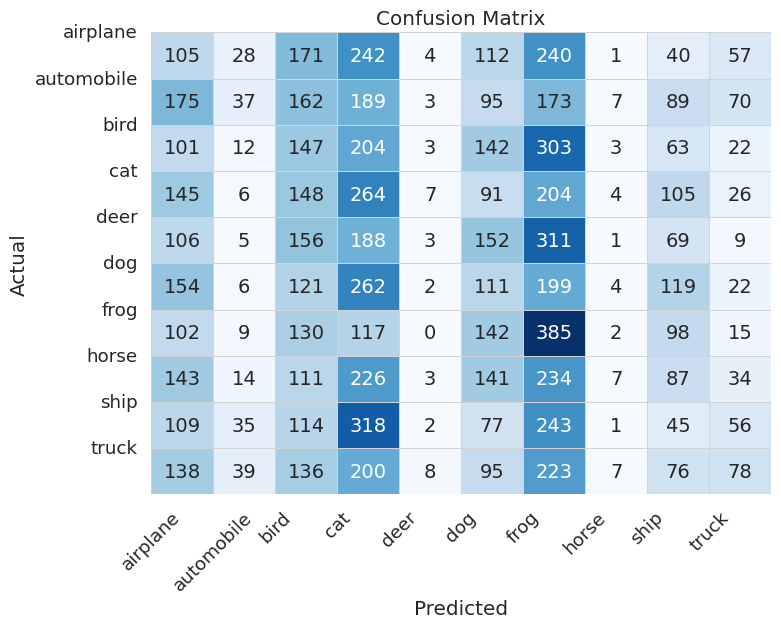

In [40]:
# Call the plot_confusion_matrix function
plot_confusion_matrix(preds, actuals, classes)